In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
default_rand = 24

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import mean_absolute_error

In [3]:
dataset = pd.read_csv('kc_house_data.csv')
dataset = dataset.drop(['id','date'], axis = 1)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  zipcode        21613 non-null  int64  
 15  lat            21613 non-null  float64
 16  long           21613 non-null  float64
 17  sqft_living15  21613 non-null  int64  
 18  sqft_l

## processing data

In [4]:
def clear_row_outliers(list_clear, dataset) :
    for column in list_clear:
        count = 0
        mean = np.mean(dataset[column])
        max_distance = np.std(dataset[column])*3
        
        for idx, row in dataset[column].T.iteritems():
            if (abs(row-mean) >= max_distance):
                dataset.drop(idx, inplace = True)
                count +=1;
        
        print(column+": "+str(count))
    
    return dataset
        
dataset = clear_row_outliers(['bedrooms','bathrooms'],dataset)

bedrooms: 75
bathrooms: 172


In [5]:
one_hot = pd.get_dummies(dataset['condition'], drop_first= True) # one-hot by pd
dataset = dataset.drop('condition', axis = 1)
dataset = dataset.join(one_hot)
dataset['Condition_2'] = dataset[2]
dataset['Condition_3'] = dataset[3]
dataset['Condition_4'] = dataset[4]
dataset['Condition_5'] = dataset[5]
dataset = dataset.drop(2, axis=1)
dataset = dataset.drop(3, axis=1)
dataset = dataset.drop(4, axis=1)
dataset = dataset.drop(5, axis=1)
dataset.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Condition_2,Condition_3,Condition_4,Condition_5
0,221900.0,3,1.00,1180,5650,1.0,0,0,7,1180,...,0,98178,47.5112,-122.257,1340,5650,0,1,0,0
1,538000.0,3,2.25,2570,7242,2.0,0,0,7,2170,...,1991,98125,47.7210,-122.319,1690,7639,0,1,0,0
2,180000.0,2,1.00,770,10000,1.0,0,0,6,770,...,0,98028,47.7379,-122.233,2720,8062,0,1,0,0
3,604000.0,4,3.00,1960,5000,1.0,0,0,7,1050,...,0,98136,47.5208,-122.393,1360,5000,0,0,0,1
4,510000.0,3,2.00,1680,8080,1.0,0,0,8,1680,...,0,98074,47.6168,-122.045,1800,7503,0,1,0,0


In [6]:
dataset = dataset.drop(['zipcode','lat','long'],axis=1)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21366 entries, 0 to 21612
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21366 non-null  float64
 1   bedrooms       21366 non-null  int64  
 2   bathrooms      21366 non-null  float64
 3   sqft_living    21366 non-null  int64  
 4   sqft_lot       21366 non-null  int64  
 5   floors         21366 non-null  float64
 6   waterfront     21366 non-null  int64  
 7   view           21366 non-null  int64  
 8   grade          21366 non-null  int64  
 9   sqft_above     21366 non-null  int64  
 10  sqft_basement  21366 non-null  int64  
 11  yr_built       21366 non-null  int64  
 12  yr_renovated   21366 non-null  int64  
 13  sqft_living15  21366 non-null  int64  
 14  sqft_lot15     21366 non-null  int64  
 15  Condition_2    21366 non-null  uint8  
 16  Condition_3    21366 non-null  uint8  
 17  Condition_4    21366 non-null  uint8  
 18  Condit

In [7]:
X_global = dataset.drop('price',axis = 1)
y_global = dataset['price']
print(X_global.shape, y_global.shape)

(21366, 18) (21366,)


# function model base

In [8]:
def Evaluating_model(y_test, y_pred):
    return (r2_score(y_test,y_pred), mean_squared_error(y_test,y_pred,squared=False), mean_absolute_error(y_test, y_pred))

In [9]:
def test_model(X, y, name_model, model):
    
    Scalers = [['None',False],['MinMaxScaler',MinMaxScaler()],['StandarScaler',StandardScaler()]]
    
    df_res = pd.DataFrame(index = None, columns =['Model','Scaler','Feature_selection','R_score (train)','R_score (test)',
                                                  'RMSE','MAE'])
    for scaler in Scalers:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = default_rand)
        
        if scaler[0] != 'None':
            sc = scaler[1].fit(X_train)
            X_train = sc.transform(X_train)
            X_test = sc.transform(X_test)
            
        sum_cols = X.columns.size
        
        for num_cols in range(4,sum_cols+1):
            print('\r', end='')
            print(scaler[0]+': '+str(num_cols)+'/'+str(sum_cols), end='')
            
            kBest = SelectKBest(f_regression,k = num_cols)
            kBest.fit(X_train, y_train)
            
            X_train_KBest = kBest.transform(X_train)
            X_test_KBest = kBest.transform(X_test)
           
            mod = model
            mod = model.fit(X_train_KBest, y_train)
            
            y_pred = mod.predict(X_test_KBest)
        
            r2_train = r2_score(y_train, mod.predict(X_train_KBest))
            r2_test, RMSE, MAE = Evaluating_model(y_test, y_pred)
            
            df_res = df_res.append(pd.Series({'Model':name_model,
                                              'Scaler':scaler[0],
                                              'Feature_selection':num_cols,
                                              'R_score (train)':r2_train,
                                              'R_score (test)':r2_test,
                                              'RMSE':RMSE,'MAE':MAE
                                             }),ignore_index = True)
    return df_res
    


## Linear regression

In [44]:
df_liner = test_model(X_global.copy(), y_global.copy(),'Linear Regresion', LinearRegression())

StandarScaler: 18/18

In [60]:
df_liner.groupby(['Feature_selection'])['RMSE'].idxmin()

Feature_selection
4      0
5      1
6     17
7      3
8     19
9      5
10    21
11    37
12     8
13    39
14    40
15    41
16    42
17    43
18    44
Name: RMSE, dtype: int64

In [65]:
df_liner = df_liner.sort_values(by = 'RMSE')

In [67]:
df_liner.sort_values(by = 'RMSE')

,Model,Scaler,Feature_selection,R_score (train),R_score (test),RMSE,MAE
43,Linear Regresion,StandarScaler,17,0.645175,0.645876,200272.668849,133983.322706
13,Linear Regresion,None,17,0.645195,0.645818,200288.919500,134021.684334
28,Linear Regresion,MinMaxScaler,17,0.645191,0.645783,200298.989564,133979.790333
44,Linear Regresion,StandarScaler,18,0.645193,0.645693,200324.259887,134016.387497
14,Linear Regresion,None,18,0.645224,0.645656,200334.894871,134034.530103
29,Linear Regresion,MinMaxScaler,18,0.645223,0.645621,200344.589399,133983.195130
42,Linear Regresion,StandarScaler,16,0.644927,0.645416,200402.632010,134056.674571
12,Linear Regresion,None,16,0.644940,0.645364,200417.336670,134104.160087
27,Linear Regresion,MinMaxScaler,16,0.644939,0.645341,200423.793383,134031.465076
41,Linear Regresion,StandarScaler,15,0.597965,0.598167,213337.187157,145203.276077


In [69]:
df_liner.loc[df_liner.groupby(['Feature_selection'])['RMSE'].idxmin()].sort_values(by = 'RMSE')

,Model,Scaler,Feature_selection,R_score (train),R_score (test),RMSE,MAE
43,Linear Regresion,StandarScaler,17,0.645175,0.645876,200272.668849,133983.322706
44,Linear Regresion,StandarScaler,18,0.645193,0.645693,200324.259887,134016.387497
42,Linear Regresion,StandarScaler,16,0.644927,0.645416,200402.632010,134056.674571
41,Linear Regresion,StandarScaler,15,0.597965,0.598167,213337.187157,145203.276077
40,Linear Regresion,StandarScaler,14,0.597933,0.598165,213337.785181,145191.046807
39,Linear Regresion,StandarScaler,13,0.588852,0.589632,215591.065594,146663.435350
8,Linear Regresion,None,12,0.588814,0.589576,215605.568910,146740.898274
37,Linear Regresion,StandarScaler,11,0.586676,0.587067,216263.721157,146962.067376
21,Linear Regresion,MinMaxScaler,10,0.579302,0.583184,217278.273811,147665.716515
5,Linear Regresion,None,9,0.567794,0.566654,221544.715299,149114.716517


In [ ]:
def vis_plot(data_want):
    data_want = 

In [75]:
df_liner_RMSE = df_liner.loc[df_liner.groupby(['Feature_selection'])['RMSE'].idxmin()]
df_liner_MAE = df_liner.loc[df_liner.groupby(['Feature_selection'])['MAE'].idxmin()]

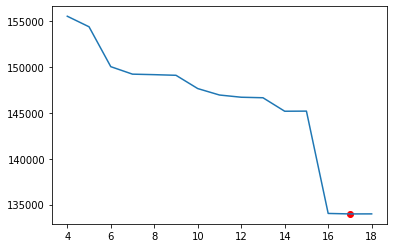

In [126]:
markers = {'StandarScaler':'s','MinMaxScaler':'v','None':'o'}

# for xp, yp,zp in zip(df_liner_RMSE['Feature_selection'],df_liner_RMSE['RMSE'],df_liner_RMSE['Scaler']):
#     plt.scatter(xp, yp, marker =markers[zp], label=zp)

#plt.plot(df_liner_RMSE['Feature_selection'],df_liner_RMSE['RMSE'])
plt.plot(df_liner_MAE['Feature_selection'],df_liner_MAE['MAE'])
sr_min = df_liner_MAE.loc[df_liner_MAE['MAE'].idxmin()]
plt.scatter(sr_min.Feature_selection,)
# plt.legend(loc='center left', bbox_to_anchor = (1,0.5))
plt.show()

In [125]:
markers = {'StandarScaler':'s','MinMaxScaler':'v','None':'o'}

def make_marker(sr):
    ma = sr['Scaler']
    markers = {'StandarScaler':'s','MinMaxScaler':'v','None':'o'}
    return markers[ma]

df_liner_MAE['Marker'] = df_liner_MAE['Scaler'].apply(make_marker)
df_liner_MAE
#plt.plot(df_liner_MAE['Feature_selection'],df_liner_MAE['MAE'],marker=df_liner_MAE['Marker'])

TypeError: string indices must be integers

In [117]:
df_liner_MAE.loc[df_liner_MAE['MAE'].idxmin()]

Model                Linear Regresion
Scaler                   MinMaxScaler
Feature_selection                  17
R_score (train)              0.645191
R_score (test)               0.645783
RMSE                    200298.989564
MAE                     133979.790333
Name: 28, dtype: object

In [118]:
df_liner_RMSE.groupby('Scaler')

In [119]:
df_liner.sort_values(by = ['RMSE','MAE'])

,Model,Scaler,Feature_selection,R_score (train),R_score (test),RMSE,MAE
43,Linear Regresion,StandarScaler,17,0.645175,0.645876,200272.668849,133983.322706
13,Linear Regresion,None,17,0.645195,0.645818,200288.919500,134021.684334
28,Linear Regresion,MinMaxScaler,17,0.645191,0.645783,200298.989564,133979.790333
44,Linear Regresion,StandarScaler,18,0.645193,0.645693,200324.259887,134016.387497
14,Linear Regresion,None,18,0.645224,0.645656,200334.894871,134034.530103
29,Linear Regresion,MinMaxScaler,18,0.645223,0.645621,200344.589399,133983.195130
42,Linear Regresion,StandarScaler,16,0.644927,0.645416,200402.632010,134056.674571
12,Linear Regresion,None,16,0.644940,0.645364,200417.336670,134104.160087
27,Linear Regresion,MinMaxScaler,16,0.644939,0.645341,200423.793383,134031.465076
41,Linear Regresion,StandarScaler,15,0.597965,0.598167,213337.187157,145203.276077


In [50]:
df_liner.groupby(['Feature_selection','Scaler']).max(['RMSE,MAE'])

R_score (train)  R_score (test)  \
Feature_selection Scaler                                           
4                 MinMaxScaler          0.528898        0.525350   
                  None                  0.528898        0.525350   
                  StandarScaler         0.528898        0.525350   
5                 MinMaxScaler          0.532290        0.529849   
                  None                  0.532290        0.529849   
                  StandarScaler         0.532290        0.529849   
6                 MinMaxScaler          0.564735        0.562714   
                  None                  0.564735        0.562714   
                  StandarScaler         0.564735        0.562714   
7                 MinMaxScaler          0.567781        0.566554   
                  None                  0.567781        0.566554   
                  StandarScaler         0.567781        0.566554   
8                 MinMaxScaler          0.567754        0.566594   
                  None                  0.567776        0.566568   
                  StandarScaler         0.567710        0.566572   
9                 MinMaxScaler          0.567817        0.566618   
                  None                  0.567794        0.566654   
                  StandarScaler         0.567802        0.566648   
10                MinMaxScaler          0.579302        0.583184   
                  None                  0.579299        0.583161   
                  StandarScaler         0.579298        0.583169   
11                MinMaxScaler          0.586670        0.587033   
                  None                  0.586681        0.587052   
                  StandarScaler         0.586676        0.587067   
12                MinMaxScaler          0.588768        0.589495   
                  None                  0.588814        0.589576   
                  StandarScaler         0.588760        0.589501   
13                MinMaxScaler          0.588882        0.589577   
                  None                  0.588882        0.589588   
                  StandarScaler         0.588852        0.589632   
14                MinMaxScaler          0.597942        0.598113   
                  None                  0.597948        0.598123   
                  StandarScaler         0.597933        0.598165   
15                MinMaxScaler          0.597968        0.598135   
                  None                  0.597975        0.598145   
                  StandarScaler         0.597965        0.598167   
16                MinMaxScaler          0.644939        0.645341   
                  None                  0.644940        0.645364   
                  StandarScaler         0.644927        0.645416   
17                MinMaxScaler          0.645191        0.645783   
                  None                  0.645195        0.645818   
                  StandarScaler         0.645175        0.645876   
18                MinMaxScaler          0.645223        0.645621   
                  None                  0.645224        0.645656   
                  StandarScaler         0.645193        0.645693   

                                          RMSE            MAE  
Feature_selection Scaler                                       
4                 MinMaxScaler   231862.425099  155562.738019  
                  None           231862.425099  155562.738019  
                  StandarScaler  231862.425099  155562.738019  
5                 MinMaxScaler   230761.172386  154411.805570  
                  None           230761.172386  154411.805570  
                  StandarScaler  230761.172386  154411.805570  
6                 MinMaxScaler   222549.585907  150056.874376  
                  None           222549.585907  150056.874376  
                  StandarScaler  222549.585907  150056.874376  
7                 MinMaxScaler   221570.138279  149239.643295  
                  None           221570.138279  149239.643295  
    

## decisionTreeRegressor

In [13]:
df_DTR = test_model(X_global.copy(), y_global.copy(),'Decision Tree Regressor', DecisionTreeRegressor(random_state = default_rand))

StandarScaler: 18/18

In [14]:
df_DTR.sort_values(by = ['RMSE','MAE'])

,Model,Scaler,Feature_selection,R_score (train),R_score (test),RMSE,MAE
12,Decision Tree Regressor,None,16,0.999256,0.481706,242288.025950,152991.867629
27,Decision Tree Regressor,MinMaxScaler,16,0.999256,0.480705,242521.940595,153249.743604
42,Decision Tree Regressor,StandarScaler,16,0.999256,0.480139,242654.106615,153211.825897
29,Decision Tree Regressor,MinMaxScaler,18,0.999256,0.474980,243855.097732,155152.014119
14,Decision Tree Regressor,None,18,0.999256,0.474943,243863.725354,155043.353588
44,Decision Tree Regressor,StandarScaler,18,0.999256,0.473923,244100.491618,155111.636739
13,Decision Tree Regressor,None,17,0.999256,0.466259,245872.144650,156022.129563
28,Decision Tree Regressor,MinMaxScaler,17,0.999256,0.465690,246003.082817,156190.084009
43,Decision Tree Regressor,StandarScaler,17,0.999256,0.464726,246224.771073,156180.602574
38,Decision Tree Regressor,StandarScaler,12,0.999241,0.403006,260033.126477,167418.246308


## Random Forest Regression


In [15]:
df_RFR = test_model(X_global.copy(), y_global.copy(),'Random Forest Regressor',
                    RandomForestRegressor(random_state = default_rand))
df_RFR.sort_values(by = ['RMSE','MAE'])

StandarScaler: 18/18

,Model,Scaler,Feature_selection,R_score (train),R_score (test),RMSE,MAE
14,Random Forest Regressor,None,18,0.962659,0.735454,173099.012506,112304.045248
29,Random Forest Regressor,MinMaxScaler,18,0.962637,0.735234,173171.014779,112314.844227
44,Random Forest Regressor,StandarScaler,18,0.962650,0.735048,173231.623347,112372.240272
13,Random Forest Regressor,None,17,0.962446,0.734045,173559.236543,112625.717556
28,Random Forest Regressor,MinMaxScaler,17,0.962442,0.733918,173600.631796,112639.523497
43,Random Forest Regressor,StandarScaler,17,0.962397,0.733703,173670.969596,112681.573087
12,Random Forest Regressor,None,16,0.962483,0.733467,173747.747098,112856.878096
27,Random Forest Regressor,MinMaxScaler,16,0.962489,0.733454,173751.981536,112840.072019
42,Random Forest Regressor,StandarScaler,16,0.962441,0.733290,173805.393779,112877.994010
25,Random Forest Regressor,MinMaxScaler,14,0.956839,0.685221,188819.587623,123431.246938


In [16]:
df_DTR.groupby(['Feature_selection']).max()

,Model,Scaler,R_score (train),R_score (test),RMSE,MAE
Feature_selection,,,,,,
4,Decision Tree Regressor,StandarScaler,0.983620,0.203469,301222.055703,198607.170995
5,Decision Tree Regressor,StandarScaler,0.993608,0.233933,294986.805757,192650.427682
6,Decision Tree Regressor,StandarScaler,0.994531,0.268702,289479.704342,189690.418985
7,Decision Tree Regressor,StandarScaler,0.996697,0.270357,288814.887412,187745.729771
8,Decision Tree Regressor,StandarScaler,0.996697,0.258143,291530.199600,189028.839288
9,Decision Tree Regressor,StandarScaler,0.997341,0.265903,289199.399378,186530.569969
10,Decision Tree Regressor,StandarScaler,0.997341,0.317206,280029.497745,183826.536011
11,Decision Tree Regressor,StandarScaler,0.997366,0.328229,276707.492342,180943.823791
12,Decision Tree Regressor,StandarScaler,0.999241,0.403006,262078.290689,167944.174545


## SVR

In [17]:
df_SVR = test_model(X_global.copy(), y_global.copy(),'SVR',
                    SVR())
df_SVR.sort_values(by = ['RMSE','MAE'])

StandarScaler: 18/18

,Model,Scaler,Feature_selection,R_score (train),R_score (test),RMSE,MAE
15,SVR,MinMaxScaler,4,-0.052913,-0.050570,344950.115393,212428.887562
0,SVR,None,4,-0.052993,-0.050628,344959.623715,212497.209492
1,SVR,None,5,-0.053254,-0.050856,344997.125139,212540.684416
2,SVR,None,6,-0.053487,-0.051068,345031.942550,212571.073928
3,SVR,None,7,-0.053614,-0.051183,345050.758580,212592.449999
30,SVR,StandarScaler,4,-0.053554,-0.051195,345052.779976,212488.335557
4,SVR,None,8,-0.053773,-0.051322,345073.568344,212605.608872
16,SVR,MinMaxScaler,5,-0.053841,-0.051407,345087.524720,212522.322435
5,SVR,None,9,-0.053866,-0.051407,345087.589442,212617.850275
6,SVR,None,10,-0.053940,-0.051475,345098.764299,212627.346952


## AdaBoostRegressor

In [18]:
df_ABR = test_model(X_global.copy(), y_global.copy(),'AdaBoostRegressor',
                    AdaBoostRegressor(random_state = default_rand))

StandarScaler: 18/18

In [19]:
df_ABR.sort_values(by =['RMSE','MAE'])

,Model,Scaler,Feature_selection,R_score (train),R_score (test),RMSE,MAE
31,AdaBoostRegressor,StandarScaler,5,0.463247,0.441445,251522.466825,181300.492582
0,AdaBoostRegressor,None,4,0.423454,0.400038,260678.815035,189851.607395
6,AdaBoostRegressor,None,10,0.409171,0.396586,261427.590580,198741.713935
30,AdaBoostRegressor,StandarScaler,4,0.405058,0.389686,262918.083900,191463.527608
16,AdaBoostRegressor,MinMaxScaler,5,0.412192,0.387767,263331.239719,193139.191120
15,AdaBoostRegressor,MinMaxScaler,4,0.406023,0.386495,263604.640220,191839.941995
1,AdaBoostRegressor,None,5,0.409154,0.382227,264519.816658,193881.471044
35,AdaBoostRegressor,StandarScaler,9,0.392384,0.375348,265988.442452,205487.442249
17,AdaBoostRegressor,MinMaxScaler,6,0.354705,0.338576,273705.764627,212703.127967
34,AdaBoostRegressor,StandarScaler,8,0.346017,0.322575,276996.633671,214344.635475


## GradientBoostingRegressor

In [20]:
GradientBoostingRegressor(random_state = default_rand)
df_GBR = test_model(X_global.copy(), y_global.copy(),'GradientBoostingRegressor',
                    GradientBoostingRegressor(random_state = default_rand))

StandarScaler: 18/18

In [21]:
df_GBR.sort_values(by = ['RMSE','MAE'])

,Model,Scaler,Feature_selection,R_score (train),R_score (test),RMSE,MAE
13,GradientBoostingRegressor,None,17,0.769421,0.728270,175433.520671,118881.882111
28,GradientBoostingRegressor,MinMaxScaler,17,0.769421,0.728241,175443.031466,118886.109881
43,GradientBoostingRegressor,StandarScaler,17,0.769421,0.728233,175445.419982,118887.994661
29,GradientBoostingRegressor,MinMaxScaler,18,0.769853,0.727909,175549.922453,118916.518601
14,GradientBoostingRegressor,None,18,0.769853,0.727880,175559.499394,118926.289951
44,GradientBoostingRegressor,StandarScaler,18,0.769853,0.727870,175562.697990,118924.425335
42,GradientBoostingRegressor,StandarScaler,16,0.767277,0.725557,176307.142056,119350.288235
12,GradientBoostingRegressor,None,16,0.767277,0.725555,176307.767348,119344.909323
27,GradientBoostingRegressor,MinMaxScaler,16,0.767277,0.725528,176316.323359,119347.237712
10,GradientBoostingRegressor,None,14,0.732426,0.685863,188626.794672,127102.637202


In [22]:
df_all = pd.concat([df_liner.sort_values(by = ['RMSE','MAE'])[:9],
                   df_RFR.sort_values(by = ['RMSE','MAE'])[:9],
                   df_ABR.sort_values(by = ['RMSE','MAE'])[:9],
                   df_GBR.sort_values(by = ['RMSE','MAE'])[:9],
                   df_SVR.sort_values(by = ['RMSE','MAE'])[:9],
                   df_DTR.sort_values(by = ['RMSE','MAE'])[:9]
                   ])
df_all.sort_values(by = ['RMSE','MAE'])

,Model,Scaler,Feature_selection,R_score (train),R_score (test),RMSE,MAE
14,Random Forest Regressor,None,18,0.962659,0.735454,173099.012506,112304.045248
29,Random Forest Regressor,MinMaxScaler,18,0.962637,0.735234,173171.014779,112314.844227
44,Random Forest Regressor,StandarScaler,18,0.962650,0.735048,173231.623347,112372.240272
13,Random Forest Regressor,None,17,0.962446,0.734045,173559.236543,112625.717556
28,Random Forest Regressor,MinMaxScaler,17,0.962442,0.733918,173600.631796,112639.523497
43,Random Forest Regressor,StandarScaler,17,0.962397,0.733703,173670.969596,112681.573087
12,Random Forest Regressor,None,16,0.962483,0.733467,173747.747098,112856.878096
27,Random Forest Regressor,MinMaxScaler,16,0.962489,0.733454,173751.981536,112840.072019
42,Random Forest Regressor,StandarScaler,16,0.962441,0.733290,173805.393779,112877.994010
13,GradientBoostingRegressor,None,17,0.769421,0.728270,175433.520671,118881.882111
